In [133]:
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
from keras.preprocessing.sequence import pad_sequences
from pickle import dump, load
import matplotlib.pyplot as plt

## Task 1

In [2]:
def task1(textfile, window_size, stride):
    # open the file as read, read text, and close file
    file = open(textfile, 'r')
    text = file.read()
    file.close()
    print(text[:50])
    
    #  strip all of the new line characters so that we 
    # have one long sequence of characters separated only 
    # by white space
    tokens = text.split()
    print(tokens[:50])
    data = ' '.join(tokens)
    print(data[:50])
    
    # get sequences of characters of length window_size+1
    sequences = []
    for i in range(0, len(data) - (window_size + 1), stride):
        sequence = data[i : i + window_size + 1]
        sequences.append(sequence)
    print('Total Sequences: %d' % len(sequences))
    
    # save sequences 
    data = '\n'.join(sequences)
    file = open('train_data.txt', 'w')
    file.write(data)
    file.close()

In [3]:
task1('beatles.txt', 3, 4)

a day in the life
i read the news today oh boy
abo
['a', 'day', 'in', 'the', 'life', 'i', 'read', 'the', 'news', 'today', 'oh', 'boy', 'about', 'a', 'lucky', 'man', 'who', 'made', 'the', 'grade', 'and', 'though', 'the', 'news', 'was', 'rather', 'sad', 'well', 'i', 'just', 'had', 'to', 'laugh', 'i', 'saw', 'the', 'photograph.', 'he', 'blew', 'his', 'mind', 'out', 'in', 'a', 'car', 'he', 'didn’t', 'notice', 'that', 'the']
a day in the life i read the news today oh boy abo
Total Sequences: 41686


## Task 2

In [5]:
def task2(train_textfile):
    # open the file as read, read text, and close file
    file = open(train_textfile, 'r')
    text = file.read()
    file.close()
    
    # get list of sequences by splitting the text by new line
    lines = text.split('\n')
    
    # get unique characters
    chars = sorted(list(set(text)))
    # get mapping of character to integer values and store in a dictionary
    char_to_i_mapping = dict((c, i) for i, c in enumerate(chars))
    # save the mapping
    dump(char_to_i_mapping, open('mapping.pkl', 'wb'))
    # get vocabulary size
    vocab_size = len(char_to_i_mapping)
    print('Vocabulary size: %d' % vocab_size)
    
    # integer encode each sequence of characters using the dictionary mapping
    sequences = []
    for line in lines:
        # integer encode line
        encoded_seq = [char_to_i_mapping[char] for char in line]
        # store
        sequences.append(encoded_seq)
    
    # now separate the integer encoded sequences into input and output
    sequences = np.array(sequences)
    X = sequences[:,:-1]
    y = sequences[:,-1]
    
    # now one-hot encode each character, meaning each character becomes a vector of length vocab_size with a 1 marked 
    # for the character and 0s elsewhere
    sequences = [to_categorical(x, num_classes=vocab_size) for x in X]
    X = np.array(sequences)
    y = to_categorical(y, num_classes=vocab_size)
    print('X shape: %s and y shape: %s' %(X.shape, y.shape))
    
    return(X, y)

In [6]:
X, y = task2('train_data.txt')

Vocabulary size: 48
X shape: (41686, 3, 48) and y shape: (41686, 48)


## Task 3

In [118]:
def task3(model, mapping, window_size, init_chars, n_chars):
    text = init_chars
    # predict a fixed number of characters
    for i in range(n_chars):
        # integer encode the characters
        encoded = [mapping[chara] for chara in text]
        # truncate sequences to a fixed length
        encoded = pad_sequences([encoded], maxlen=window_size, truncating='pre')
        # one hot encode
        encoded = to_categorical(encoded, num_classes=len(mapping))
        # predict the next character
        pred_char = model.predict_classes(encoded, verbose=0)
        # reverse mapping of predicted character (integer to character)
        out_char = ''
        for char, index in mapping.items():
            if index == pred_char:
                out_char = char
                break
        # append to input
        text += out_char
    return text

In [119]:
# load the mapping
mapping = load(open('mapping.pkl', 'rb'))
 
# test start of rhyme
print(task3(model, mapping, 3, 'a d', 20))
# test mid-line
print(task3(model, mapping, 3, 'now', 20))
# test not in original
print(task3(model, mapping, 3, 'you', 20))

a day the sun she sun s
now i want to the sun s
you say the sun she sun


## Task 4

In [170]:
class MyCustomCallback(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs=None):
        mapping = load(open('mapping.pkl', 'rb'))
        random_index = np.random.randint(low=0, high=X.shape[0], size=1)
        if epoch%2 == 0:
            prediction = model.predict_classes(np.reshape(X[random_index], (1, X[0].shape[0], X[0].shape[1])))
            out_char = ''
            for char, index in mapping.items():
                if index == prediction:
                    out_char = char
                    break
            print(out_char) # return prediction

def task4(model, X, y, n_epochs):
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # fit model
    history = model.fit(X, y, epochs=n_epochs, verbose=1, callbacks=[MyCustomCallback()])
    
    # Plot training loss values vs epochs
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.title('Loss vs. Epochs')
    plt.xticks(np.arange(0, n_epochs, step=1))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper right')
    plt.savefig('epoch_loss.png')
    plt.show()

## Task 5

In [131]:
# open the file as read, read text, and close file
file = open('train_data.txt', 'r')
text = file.read()
file.close()

# get list of sequences by splitting the text by new line
lines = text.split('\n')

# get unique characters
chars = sorted(list(set(text)))
# get mapping of character to integer values and store in a dictionary
char_to_i_mapping = dict((c, i) for i, c in enumerate(chars))
# save the mapping
dump(char_to_i_mapping, open('mapping.pkl', 'wb'))
# get vocabulary size
vocab_size = len(char_to_i_mapping)
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 48


In [150]:
# SimpleRNN
model1 = Sequential() 
model1.add(SimpleRNN(100, input_dim=vocab_size)) 
model1.add(Dense(vocab_size))
model1.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 100)               14900     
_________________________________________________________________
dense_7 (Dense)              (None, 48)                4848      
Total params: 19,748
Trainable params: 19,748
Non-trainable params: 0
_________________________________________________________________


/Users/annanau/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/annanau/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(100, input_shape=(None, 48))`
  This is separate from the ipykernel package so we can avoid doing imports until


In [155]:
model.save('model1.h5')

Epoch 1/4
41686/41686 [==============================] - 9s 225us/step - loss: 9.9363
t
Epoch 2/4
41686/41686 [==============================] - 9s 210us/step - loss: 9.9363
Epoch 3/4
41686/41686 [==============================] - 9s 218us/step - loss: 9.9363
 
Epoch 4/4
41686/41686 [==============================] - 9s 225us/step - loss: 9.9363


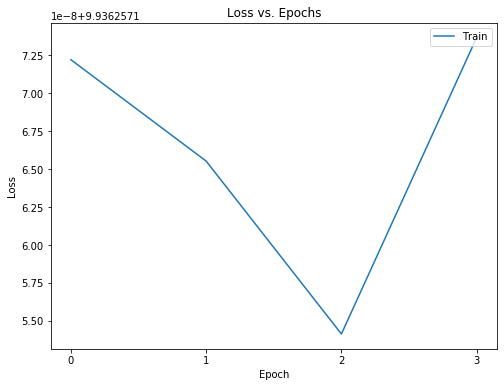

In [171]:
task4(model1, X, y, n_epochs=4)

In [ ]:
# SimpleRNN
model2 = Sequential() 
model2.add(SimpleRNN(100, input_dim=vocab_size)) 
model2.add(Dense(vocab_size))
model2.summary()

In [ ]:
model.save('model2.h5')

In [ ]:
# SimpleRNN
model3 = Sequential() 
model3.add(SimpleRNN(100, input_dim=vocab_size)) 
model3.add(Dense(vocab_size))
model3.summary()

In [ ]:
model.save('model3.h5')

In [ ]:
# SimpleRNN
model4 = Sequential() 
model4.add(SimpleRNN(100, input_dim=vocab_size)) 
model4.add(Dense(vocab_size))
model4.summary()

In [122]:
# LSTM: 
model5 = Sequential()
model5.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
model5.add(Dense(vocab_size, activation='softmax'))
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 75)                37200     
_________________________________________________________________
dense_3 (Dense)              (None, 48)                3648      
Total params: 40,848
Trainable params: 40,848
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# LSTM: 
model6 = Sequential()
model6.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
model6.add(Dense(vocab_size, activation='softmax'))
print(model5.summary())

In [ ]:
# LSTM: 
model7 = Sequential()
model7.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
model7.add(Dense(vocab_size, activation='softmax'))
print(model5.summary())

In [ ]:
# LSTM: 
model8 = Sequential()
model8.add(LSTM(75, input_shape=(X.shape[1], X.shape[2])))
model8.add(Dense(vocab_size, activation='softmax'))
print(model5.summary())

In [40]:
model.save('model.h5')

## Other

In [ ]:
def task4(model, train_data, n_epochs, window_size, stride):
    # generate training sequences
    task1('beatles.txt', window_size, stride)
    
    # get input X and output array y for training
    X, y = task2('train_data.txt')
    
    # now train the model
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit model
    model.fit(X, y, epochs=n_epochs, verbose=1)

In [42]:
def task3(model, window_size, init_chars, n_chars):
    in_text = init_chars
    for char in range(n_chars):
        predicted = model.predict_classes(init_chars, verbose=0)
        print(predicted)
        # append to input
        in_text += predicted
    print(in_text)

In [2]:
# open the file as read, read text, and close file
file = open('train_data.txt', 'r')
text = file.read()
file.close()

# get list of sequences by splitting the text by new line
lines = text.split('\n')

# get unique characters
chars = sorted(list(set(text)))
# get mapping of character to integer values and store in a dictionary
char_to_i_mapping = dict((c, i) for i, c in enumerate(chars))
# save the mapping
dump(char_to_i_mapping, open('mapping.pkl', 'wb'))
# get vocabulary size
vocab_size = len(char_to_i_mapping)
print('Vocabulary size: %d' % vocab_size)

Vocabulary size: 48


In [89]:
class PredictionCallback(keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict_classes(self)
    print('prediction: {} at epoch: {}'.format(y_pred, epoch))

TypeError: 'History' object is not subscriptable